<h1>Configuracion inicial</h1>

Para poder ejecutar este Notebook, hace falta instalar las dependencias. Para ello, creamos un entorno virtual y hacemos `pip install -r requirements.txt`. 

Antes de poder hacer eso, debemos tener instalado Rust para poder usar el paquete `cirq`. 

Se recomienda usar WSL o Linux para ello, y escribir en la consola el siguiente comando: 

```console
    curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh`
```
 y proceder con la instalación por defecto. 

In [ ]:
# importamos todos los paquetes que vayamos a necesitar.
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Definimos los qubits a utilizar
qubits = [cirq.LineQubit(i) for i in range(3)]  # Usaremos 3 qubits: dos para teleportación y uno ancilla

<h3> Definición del oráculo </h3>
El oráculo en el algoritmo de Grover marca el estado objetivo. En Qiskit, se realiza mediante operadores controlados; en Cirq, lo replicamos con una puerta personalizada:

In [3]:
# Oráculo para marcar el estado objetivo |11>
def grover_oracle(qubits):
    circuit = cirq.Circuit()
    # Aplicar X al primer y segundo qubit para preparar el estado |11>
    circuit.append([cirq.X(qubits[0]), cirq.X(qubits[1])])
    # Aplicar un Toffoli controlado en el tercer qubit
    circuit.append(cirq.TOFFOLI(qubits[0], qubits[1], qubits[2]))
    # Revertir las X
    circuit.append([cirq.X(qubits[0]), cirq.X(qubits[1])])
    return circuit


<h3> Construcción del operador difusor </h3>
El difusor refleja el estado actual respecto a la media de amplitudes:

In [4]:
# Operador difusor
def diffusion_operator(qubits):
    circuit = cirq.Circuit()
    # Aplicar H a todos los qubits
    circuit.append(cirq.H.on_each(*qubits[:2]))
    # Aplicar X a todos los qubits
    circuit.append(cirq.X.on_each(*qubits[:2]))
    # Aplicar un Z controlado (equivalente a un Toffoli invertido)
    circuit.append(cirq.TOFFOLI(qubits[0], qubits[1], qubits[2]))
    # Revertir las X
    circuit.append(cirq.X.on_each(*qubits[:2]))
    # Revertir las H
    circuit.append(cirq.H.on_each(*qubits[:2]))
    return circuit


<h3> Construcción del circuito completo </h3>
Combinamos el oráculo y el difusor para construir el circuito de Grover

In [5]:
# Construir el circuito completo
circuit = cirq.Circuit()

# Estado inicial |000>
circuit.append(cirq.H.on_each(*qubits[:2]))  # Aplicar H a los qubits de datos

# Iteraciones de Grover
iterations = 1  # Usamos una iteración para este ejemplo
for _ in range(iterations):
    circuit += grover_oracle(qubits)
    circuit += diffusion_operator(qubits)

# Medición
circuit.append(cirq.measure(*qubits[:2], key='result'))

# Mostrar el circuito
print("Circuito construido:")
print(circuit)


Circuito construido:
0: ───H───X───@───X───H───X───@───X───H───M('result')───
              │               │           │
1: ───H───X───@───X───H───X───@───X───H───M─────────────
              │               │
2: ───────────X───────────────X─────────────────────────


In [ ]:
def plot_histogram(result):
    # Crear un histograma con los resultados de la simulación
    plt.bar(result.histogram(key="result").keys(), result.histogram(key="result").values())
    
    plt.xlabel('Estado')
    plt.ylabel('Conteo')
    plt.show()

<h3> Simulación </h3>
Simulamos el circuito y mostramos los resultados

Resultados:
Counter({0: 624, 2: 141, 1: 125, 3: 110})


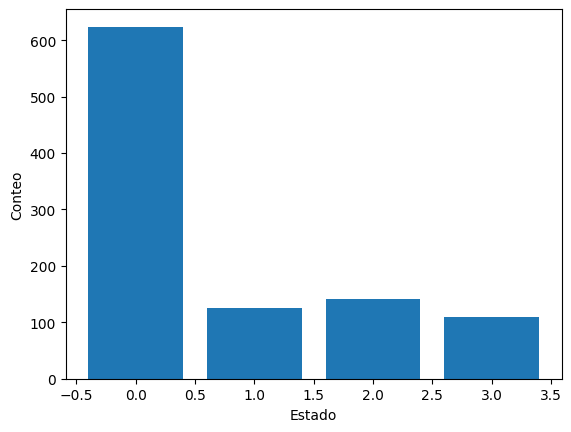

In [11]:
# Simulador de Cirq
simulator = cirq.Simulator()

# Simular el circuito
result = simulator.run(circuit, repetitions=1000)

# Mostrar resultados
print("Resultados:")
print(result.histogram(key='result'))
# plotear el resultado
plot_histogram(result)